In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('../input/train.csv')
df_train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


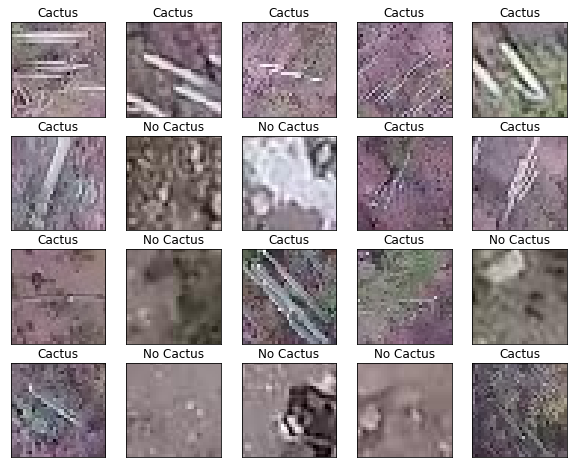

In [3]:
plt.figure(figsize=(10, 8))
for i in range(0, 20):
    plt.subplot(4, 5, i+1)
    data = df_train.loc[i]
    img = mpimg.imread('../input/train/train/{}'.format(data.id))
    plt.imshow(img / 255, 'gray')
    plt.title('Cactus' if data.has_cactus else 'No Cactus')
    plt.xticks([])
    plt.yticks([])

In [4]:
filenames = ['../input/train/train/' + fname for fname in df_train['id'].tolist()]
labels = df_train['has_cactus'].tolist()

train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames, labels, train_size=0.9, random_state=42)

In [5]:
train_data = tf.data.Dataset.from_tensor_slices((tf.constant(filenames), tf.constant(labels)))
val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels)))

In [6]:
def convert_image(filename, label=''):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img)
    img = (tf.cast(img, tf.float32)/127.5)-1
    img = tf.image.resize(img, (32, 32))
    return img, label

In [7]:
train_data = (train_data.map(convert_image).shuffle(buffer_size=10000).batch(32))
val_data = (val_data.map(convert_image).shuffle(buffer_size=10000).batch(32))

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(train_data.repeat(), epochs=20, steps_per_epoch=round(len(train_filenames)/32), validation_data=val_data.repeat(), validation_steps=20)

Epoch 1/20
492/492 [==============================] - 31s 63ms/step - loss: 0.1875 - acc: 0.9234 - val_loss: 0.0929 - val_acc: 0.9703
Epoch 2/20
492/492 [==============================] - 29s 59ms/step - loss: 0.0990 - acc: 0.9658 - val_loss: 0.0859 - val_acc: 0.9719
Epoch 3/20
492/492 [==============================] - 29s 59ms/step - loss: 0.0803 - acc: 0.9703 - val_loss: 0.0978 - val_acc: 0.9683
Epoch 4/20
492/492 [==============================] - 29s 58ms/step - loss: 0.0761 - acc: 0.9733 - val_loss: 0.0719 - val_acc: 0.9781
Epoch 5/20
492/492 [==============================] - 29s 60ms/step - loss: 0.0714 - acc: 0.9745 - val_loss: 0.0630 - val_acc: 0.9797
Epoch 6/20
492/492 [==============================] - 29s 60ms/step - loss: 0.0639 - acc: 0.9771 - val_loss: 0.0524 - val_acc: 0.9825
Epoch 7/20
492/492 [==============================] - 29s 59ms/step - loss: 0.0585 - acc: 0.9792 - val_loss: 0.0746 - val_acc: 0.9688
Epoch 8/20
492/492 [==============================] - 29s 58ms

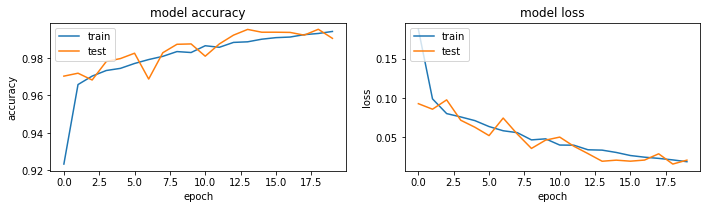

In [13]:
fig = plt.figure(figsize=(18, 6))

plt.subplot2grid((2, 3), (0, 0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot2grid((2, 3), (0, 1))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [14]:
import glob
filenames = glob.glob('../input/test/test/*.jpg')

test_data = tf.data.Dataset.from_tensor_slices((tf.constant(filenames)))
test_data = test_data.map(convert_image)
test_data = test_data.batch(32)

In [15]:
predictions = model.predict(test_data, steps=len(filenames))

In [16]:
ids = [fname.split('/')[4] for fname in filenames]
has_cactus = predictions

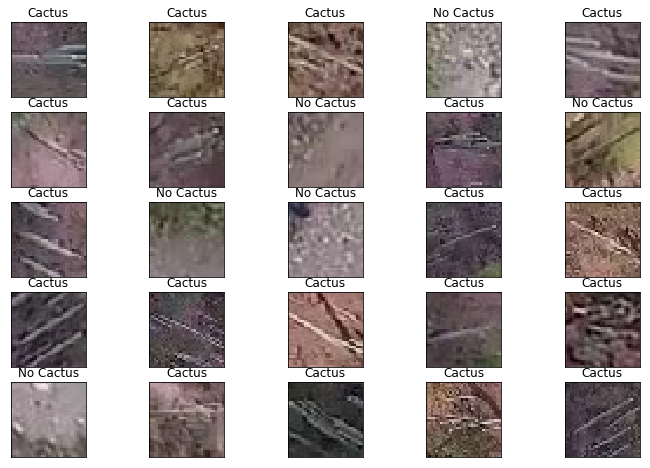

In [17]:
plt.figure(figsize=(12, 8))
for i in range(0, len(predictions[:25])):
    plt.subplot(5, 5, i+1)
    img = mpimg.imread(filenames[i])
    plt.imshow(img)
    plt.title('Cactus' if predictions[i] >= 0.5 else 'No Cactus')
    plt.xticks([])
    plt.yticks([])

In [18]:
import csv

csv_data = [['id', 'has_cactus']]

for i in range(0, len(ids)):
    csv_data.append([ids[i], has_cactus[i][0]])

with open('submission.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(csv_data)

csv_file.close()

In [19]:
!cat submission.csv